In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

1. Read and explore the data

In [ ]:
df=pd.read_json("/content/drive/MyDrive/NLPLab/Sarcasm_Headlines_Dataset.json", lines=True)
df.head()

,is_sarcastic,headline,article_link
0,1,thirtysomething scientists unveil doomsday clo...,https://www.theonion.com/thirtysomething-scien...
1,0,dem rep. totally nails why congress is falling...,https://www.huffingtonpost.com/entry/donna-edw...
2,0,eat your veggies: 9 deliciously different recipes,https://www.huffingtonpost.com/entry/eat-your-...
3,1,inclement weather prevents liar from getting t...,https://local.theonion.com/inclement-weather-p...
4,1,mother comes pretty close to using word 'strea...,https://www.theonion.com/mother-comes-pretty-c...


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28619 entries, 0 to 28618
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   is_sarcastic  28619 non-null  int64 
 1   headline      28619 non-null  object
 2   article_link  28619 non-null  object
dtypes: int64(1), object(2)
memory usage: 670.9+ KB


0    14985
1    13634
Name: is_sarcastic, dtype: int64


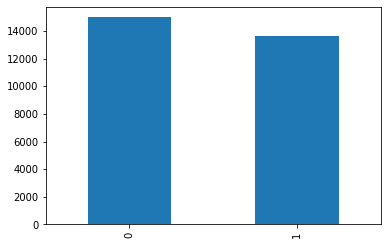

In [ ]:
print(df.is_sarcastic.value_counts())
df.is_sarcastic.value_counts().plot(kind='bar')

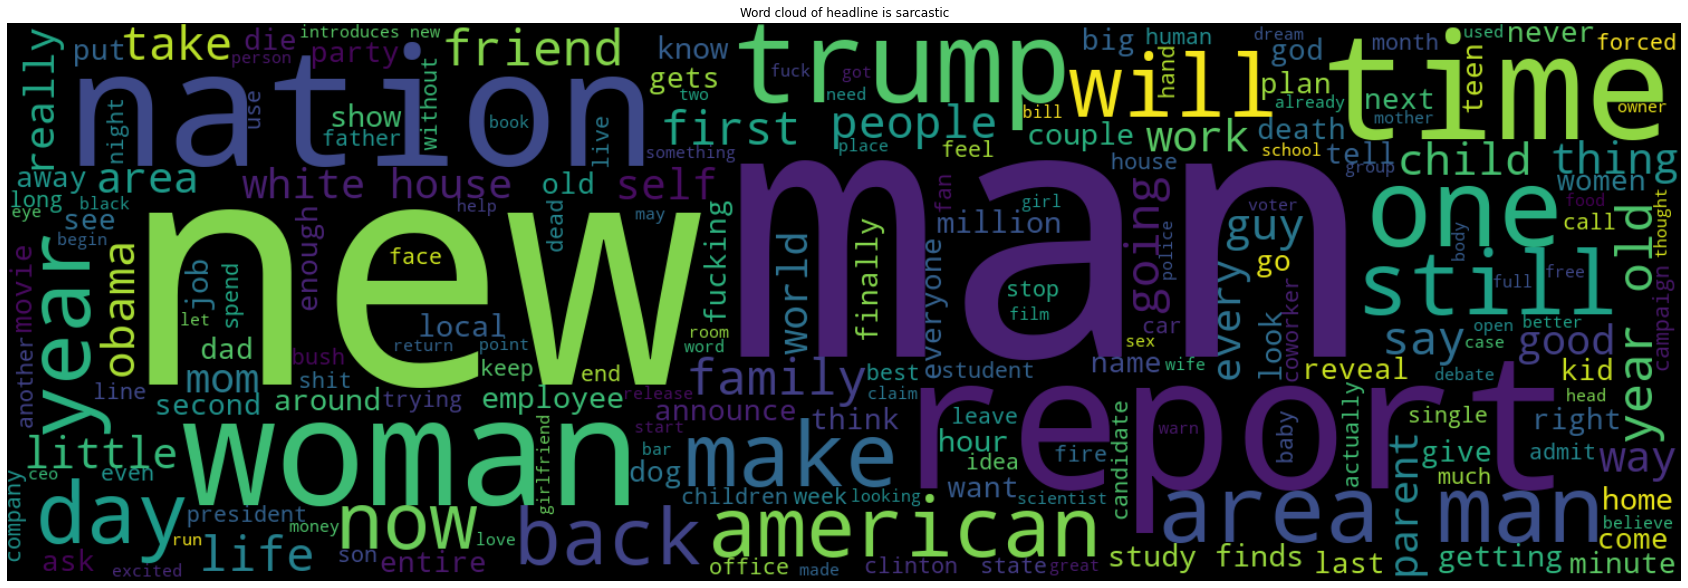

In [ ]:
# Show wordscloud for sarcastic
text = " ".join(df.loc[df.is_sarcastic ==1].headline)

wordcloud = WordCloud(width=1500, height=500).generate(text)

plt.figure( figsize=(30,20))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title('Word cloud of headline is sarcastic')
plt.axis("off")
plt.show()

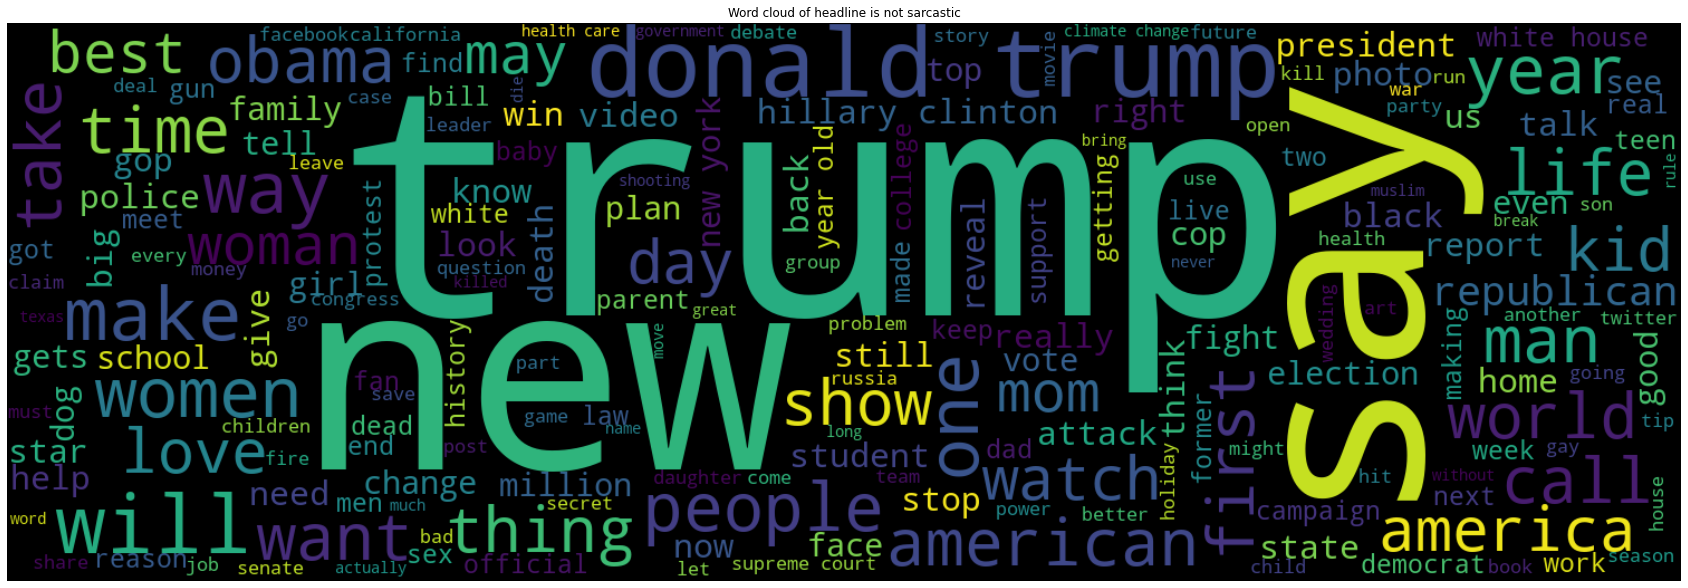

In [ ]:
# Show worscloud for non-sarcastic
text = " ".join(df.loc[df.is_sarcastic ==0].headline)

wordcloud = WordCloud(width=1500, height=500)
wordcloud.generate(text)

plt.figure( figsize=(30,20))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title('Word cloud of headline is not sarcastic')
plt.show()

**2. Retain relevant columns**

In [ ]:
#as the Article link column is not benefical for model building so droppping the column

In [ ]:


df.drop('article_link',axis=1,inplace=True)

**3. Get length of each sentence**

In [ ]:
df['length']=df['headline'].apply(lambda x : len(x.split(" ")))

In [ ]:
df.head()

,is_sarcastic,headline,length
0,1,thirtysomething scientists unveil doomsday clo...,8
1,0,dem rep. totally nails why congress is falling...,13
2,0,eat your veggies: 9 deliciously different recipes,7
3,1,inclement weather prevents liar from getting t...,8
4,1,mother comes pretty close to using word 'strea...,9


**4. Define parameters**

In [ ]:
df.length.max()

151

In [ ]:
import numpy as np

Review length: 
Mean 10.05 words (3.390879)


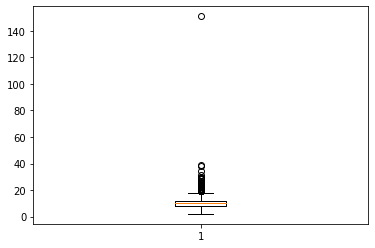

In [ ]:


# Summarize review length
print("Review length: ")

print("Mean %.2f words (%f)" % (np.mean(df.length), np.std(df.length)))
# plot review length
plt.boxplot(df.length)
plt.show()

In [ ]:
max_length=32
embedding_dim=50

**6. Create features and labels**

In [ ]:
from sklearn.model_selection import train_test_split
X=df['headline'].values
y=df['is_sarcastic'].values


In [ ]:
X.shape

(28619,)

In [ ]:
y.shape

(28619,)

**7. Get vocabulary size**

In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer

In [ ]:
tokenizer= Tokenizer()
tokenizer.fit_on_texts(X)

In [ ]:
word_index=tokenizer.word_index

In [ ]:
vocab_size=len(word_index)+1

In [ ]:
print('vocabulary size',vocab_size)

vocabulary size 30885


In [ ]:
X=tokenizer.texts_to_sequences(X)

In [ ]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [ ]:
X = pad_sequences(X,maxlen=max_length,padding='post',truncating='post')

In [ ]:
X[20]

array([1318, 1711,  395,    4,  883,   24, 4184,    2, 1484,  816, 2962,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0],
      dtype=int32)

**8. Create a weight matrix using GloVe embeddings**

In [ ]:
glove_file ='/content/drive/MyDrive/NLPLab/glove.6B.50d.txt'
embeddings ={}

In [ ]:
for tok in open(glove_file):
  word = tok.split(" ")[0]
  embd = tok.split(" ")[1:]
  embd =np.asarray(embd,dtype='float32')

  embeddings[word]=embd

In [ ]:
embedding_matrix=np.zeros((vocab_size,embedding_dim))


In [ ]:
for word, i in tokenizer.word_index.items():
  embedding_vector = embeddings.get(word)
  if embedding_vector is not None:
    embedding_matrix[i]=embedding_vector

In [ ]:
len(embeddings)

400000

In [ ]:
x_train,x_test,y_train,y_test=train_test_split(X,y,random_state=44)

9. Define and compile a Bidirectional LSTM model.

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint   # save model
from tensorflow.keras.models import Sequential,load_model
from tensorflow.keras.layers import Dense, Embedding, Flatten,Dropout,Input, LSTM,Bidirectional,LeakyReLU

In [ ]:
model = Sequential()
model.add(Embedding(vocab_size,embedding_dim,weights=[embedding_matrix],input_length=max_length))
model.add(Bidirectional(LSTM(64,return_sequences=True,dropout=0.2, recurrent_dropout=0.2)))
model.add(Bidirectional(LSTM(32),))
model.add(Dense(256,activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(64,activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1,activation='sigmoid'))

In [ ]:

checkpoint = ModelCheckpoint(
    'models/BiLSTM.h5',
    monitor='val_accuracy',
    save_best_only=True,
    verbose=1
)

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 32, 50)            1544250   
_________________________________________________________________
bidirectional (Bidirectional (None, 32, 128)           58880     
_________________________________________________________________
bidirectional_1 (Bidirection (None, 64)                41216     
_________________________________________________________________
dense (Dense)                (None, 256)               16640     
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                16448     
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0

In [ ]:
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

**10. Fit the model and check the validation accuracy**

In [ ]:
training_history=model.fit(x_train,y_train,batch_size=32,epochs=5,validation_data=(x_test, y_test), callbacks=[checkpoint])

Epoch 1/5
671/671 [==============================] - 99s 136ms/step - loss: 0.5429 - accuracy: 0.7080 - val_loss: 0.3540 - val_accuracy: 0.8394

Epoch 00001: val_accuracy improved from -inf to 0.83941, saving model to models/BiLSTM.h5
Epoch 2/5
671/671 [==============================] - 89s 133ms/step - loss: 0.2856 - accuracy: 0.8802 - val_loss: 0.3089 - val_accuracy: 0.8667

Epoch 00002: val_accuracy improved from 0.83941 to 0.86667, saving model to models/BiLSTM.h5
Epoch 3/5
671/671 [==============================] - 89s 133ms/step - loss: 0.1854 - accuracy: 0.9277 - val_loss: 0.2910 - val_accuracy: 0.8869

Epoch 00003: val_accuracy improved from 0.86667 to 0.88693, saving model to models/BiLSTM.h5
Epoch 4/5
671/671 [==============================] - 90s 134ms/step - loss: 0.1150 - accuracy: 0.9576 - val_loss: 0.3093 - val_accuracy: 0.8829

Epoch 00004: val_accuracy did not improve from 0.88693
Epoch 5/5
671/671 [==============================] - 94s 139ms/step - loss: 0.0736 - accu

In [ ]:
from sklearn.metrics import confusion_matrix,accuracy_score

In [ ]:
y_pred = model.predict_classes(x_test, batch_size = 32)

In [ ]:
accuracy_score(y_test,y_pred)

0.8812019566736548

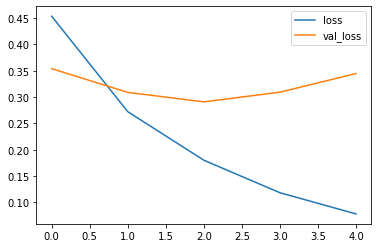

In [ ]:
plt.plot(training_history.history['loss'], label='loss')
plt.plot(training_history.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

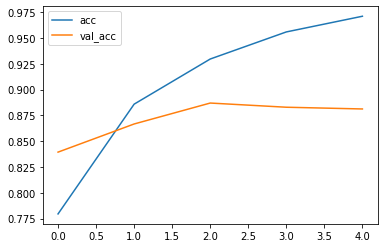

In [ ]:
plt.plot(training_history.history['accuracy'], label='acc')
plt.plot(training_history.history['val_accuracy'], label='val_acc')
plt.legend()
plt.show()